In [84]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [86]:
df = pd.read_csv('feature_selection_top_states.csv', index_col = 'Date', parse_dates = True)
df.head()

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California
2020-03-04,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,5.0,...,873999,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California
2020-03-05,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,5.0,...,873999,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California


In [87]:
df.shape

(7900, 52)

In [88]:
ca_df = df[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.shape

(790, 52)

In [89]:
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.shape

(790, 51)

In [90]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [91]:
ca_test

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,new_cases_100_mean,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,2.0,2.0,1.0,1226.0,2.0,2.0,3.0,1.0,0.0,0.0,...,8284.35,876556,0.223654,5.0,10.061111,1.894541,5.897176,1.830623,0.814215,0
2022-01-02,2.0,2.0,1.0,1265.0,2.0,2.0,3.0,1.0,0.0,0.0,...,8656.50,876556,0.223654,5.0,12.244444,1.894541,5.897176,1.830623,0.814215,44710
2022-01-03,2.0,2.0,1.0,1282.0,2.0,2.0,3.0,1.0,0.0,0.0,...,9104.57,876556,0.225636,5.0,12.583333,1.894541,5.897176,1.830623,0.815603,46362
2022-01-04,2.0,2.0,1.0,1398.0,2.0,2.0,3.0,1.0,0.0,0.0,...,10510.30,876556,0.227059,5.0,14.455556,1.894541,5.897176,1.830623,0.816247,141752
2022-01-05,2.0,2.0,1.0,1434.0,2.0,2.0,3.0,1.0,0.0,0.0,...,10903.91,876556,0.229742,5.0,15.127778,1.894541,5.897176,1.830623,0.817361,59311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,1.0,1.0,1.0,102.0,2.0,2.0,3.0,0.0,0.0,0.0,...,23233.58,876556,0.363439,5.0,28.561111,1.894541,5.897176,1.830623,0.818862,4531
2022-04-26,1.0,1.0,1.0,122.0,2.0,2.0,3.0,0.0,0.0,0.0,...,22944.34,876556,0.363587,5.0,28.277778,1.894541,5.897176,1.830623,0.818984,16180
2022-04-27,1.0,1.0,1.0,133.0,2.0,2.0,3.0,0.0,0.0,0.0,...,20750.51,876556,0.363872,5.0,25.316667,1.894541,5.897176,1.830623,0.819211,1852


In [92]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

EARLY STOPPING XGBOOST MODEL

In [93]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_ca_train, y_ca_train,
        eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], verbose=True)

[0]	validation_0-rmse:7812.77512	validation_1-rmse:50205.30747
[1]	validation_0-rmse:5865.98955	validation_1-rmse:47895.19566
[2]	validation_0-rmse:4444.68222	validation_1-rmse:46798.68219
[3]	validation_0-rmse:3466.06018	validation_1-rmse:46251.55654
[4]	validation_0-rmse:2713.73122	validation_1-rmse:45030.21533
[5]	validation_0-rmse:2187.86633	validation_1-rmse:44665.06789
[6]	validation_0-rmse:1800.01527	validation_1-rmse:44273.21696
[7]	validation_0-rmse:1531.85699	validation_1-rmse:44248.01225
[8]	validation_0-rmse:1312.29635	validation_1-rmse:43961.38440
[9]	validation_0-rmse:1122.58180	validation_1-rmse:43735.58575
[10]	validation_0-rmse:999.54784	validation_1-rmse:43623.68600
[11]	validation_0-rmse:893.83621	validation_1-rmse:43574.68152
[12]	validation_0-rmse:798.62467	validation_1-rmse:43625.83119
[13]	validation_0-rmse:745.96789	validation_1-rmse:43601.38157
[14]	validation_0-rmse:682.94841	validation_1-rmse:43556.40168
[15]	validation_0-rmse:629.60617	validation_1-rmse:4355

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

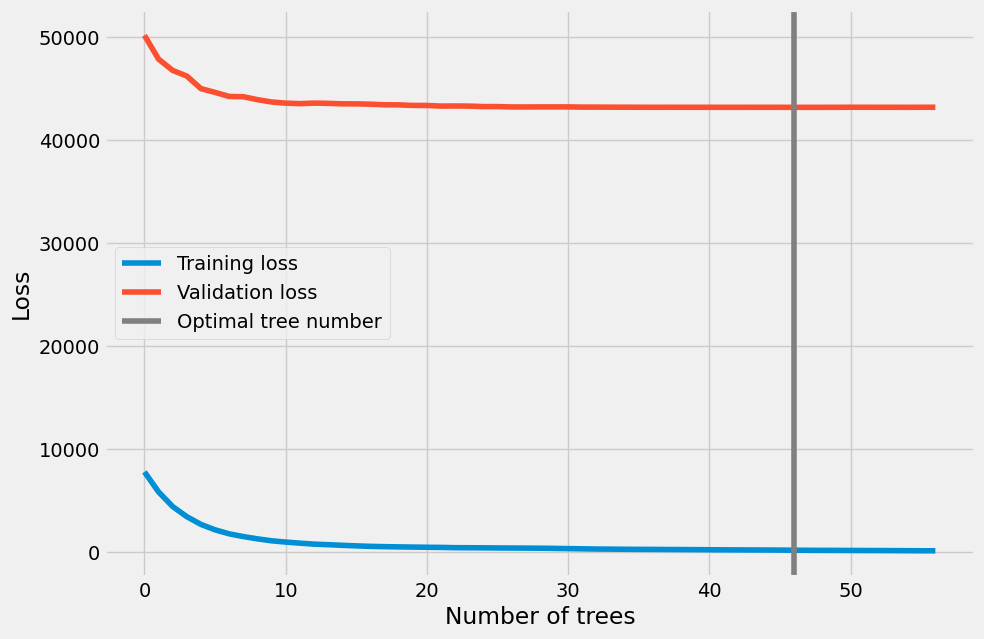

In [94]:
results = reg.evals_result()=

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [95]:
reg.best_iteration

46

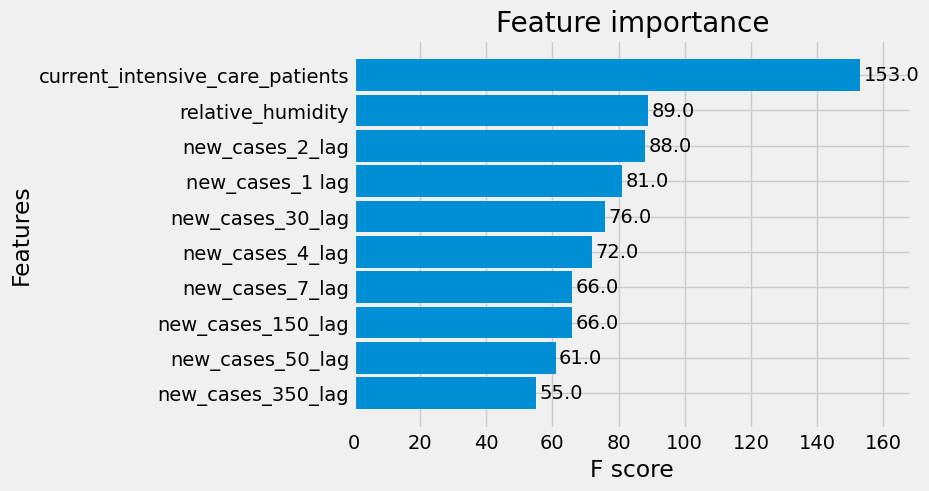

In [96]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

In [97]:
ca_test['MW_Prediction'] = reg.predict(X_ca_test)
full_set = pd.concat([ca_test, ca_train], sort=False)

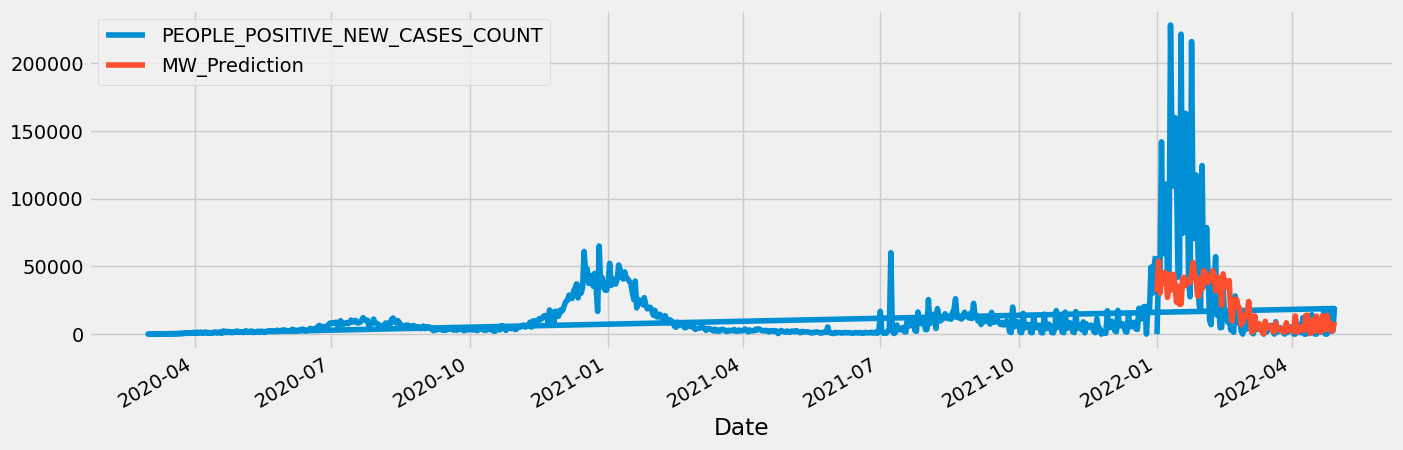

In [98]:
_ = full_set[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction']].plot(figsize=(15, 5))

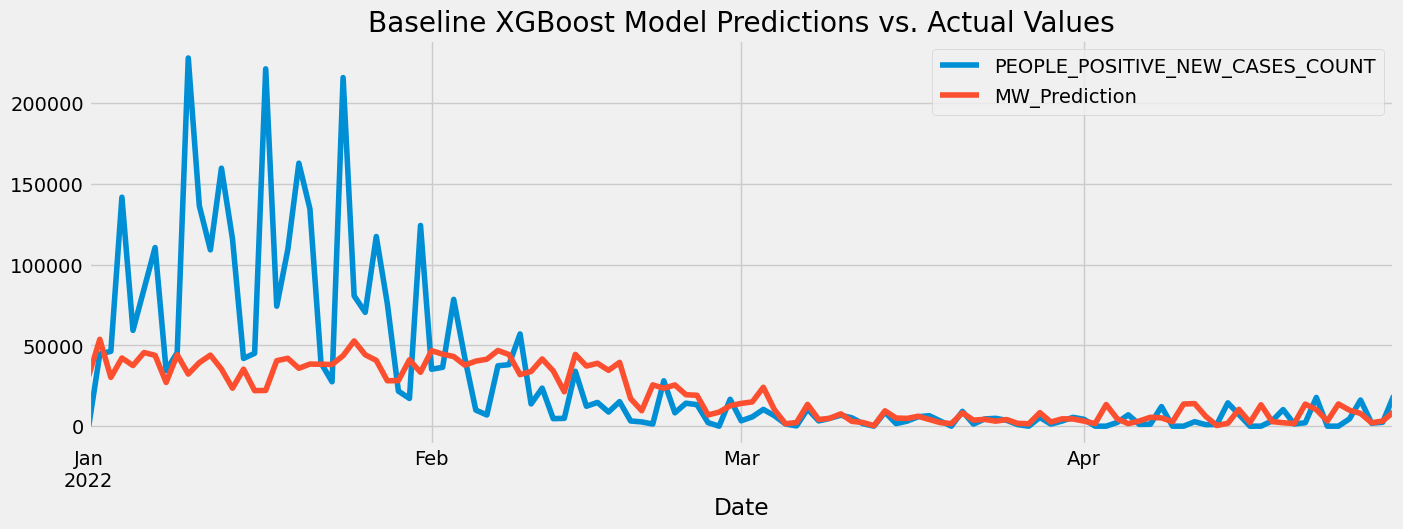

In [109]:
_ = ca_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction']].plot(figsize=(15, 5), title = 'Baseline XGBoost Model Predictions vs. Actual Values')

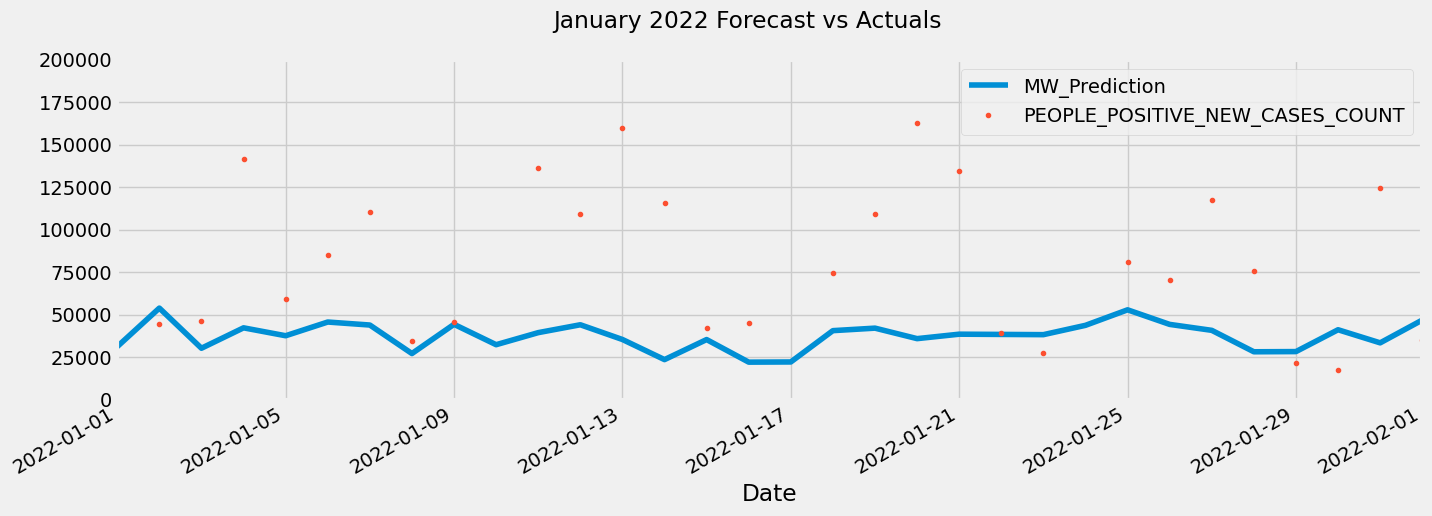

In [77]:
# look at just the first month of predictions
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='02-01-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

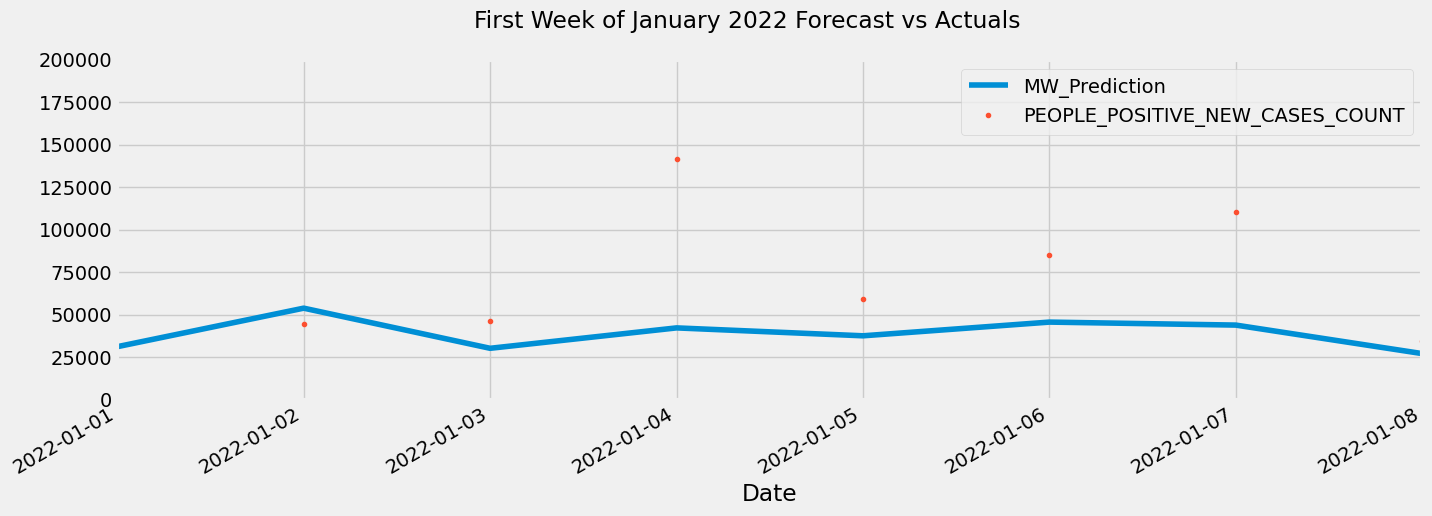

In [78]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='01-08-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('First Week of January 2022 Forecast vs Actuals')

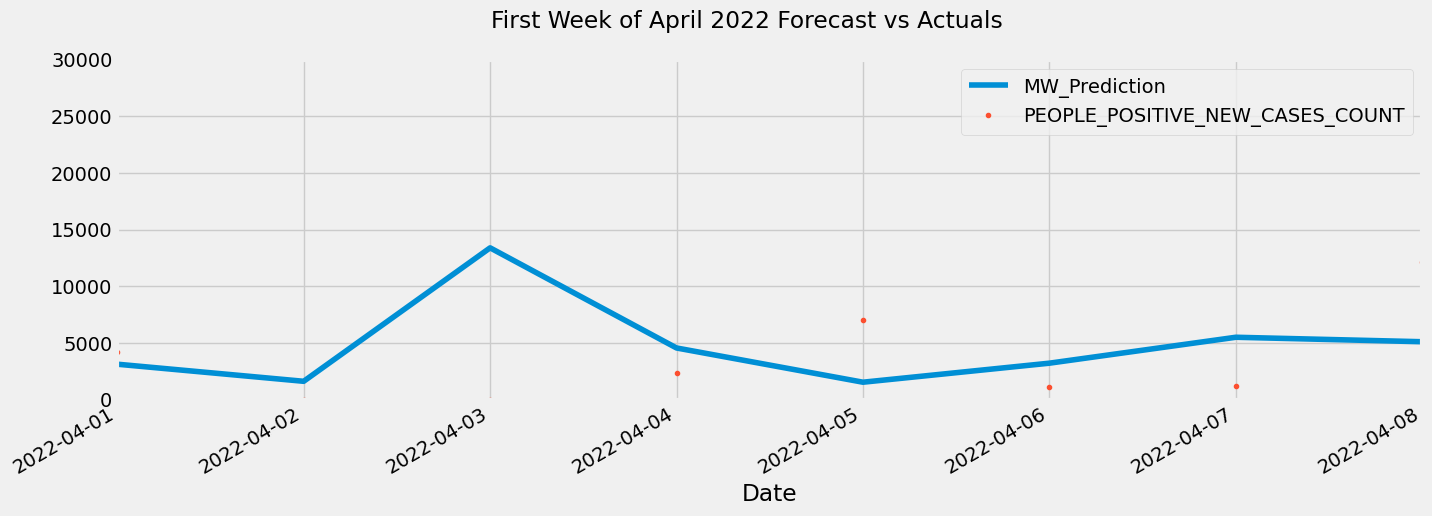

In [79]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 30000)
ax.set_xbound(lower='04-01-2022', upper='04-08-2022')
plot = plt.suptitle('First Week of April 2022 Forecast vs Actuals')

In [114]:
model_rmse = mean_squared_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'], squared=False)
model_mae = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'])
print('Baseline Model Test RMSE: ', model_rmse)
print('Baseline Model Test MAE: ', model_mae)

#naive forecast for mase calculation
naive_forecast = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = model_mae / mae_naive
print('Baseline Model Test MASE: ', mase)

Baseline Model Test RMSE:  43530.829231071526
Baseline Model Test MAE:  21880.612493178425
Baseline Model Test MASE:  0.9354808847424675


HYPERPARAMETER TUNING


In [100]:
xgb_regressor = xgb.XGBRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_ca_train, y_ca_train, 
                eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], 
                early_stopping_rounds=10, verbose=False)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   2.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   4.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   4.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   5.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   4.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   4.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   4.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   6.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   7.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   7.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=   8.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   8.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=   9.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=   8.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  18.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  19.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  21.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   2.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  23.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   2.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   3.4s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   4.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   6.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.6s[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.6s

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   6.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   6.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   6.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   7.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   7.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   7.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   8.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=  13.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  13.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=   8.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=  11.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  13.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  11.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=   9.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  19.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  22.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  22.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  21.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   3.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   5.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   5.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   8.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   8.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   8.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=   9.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   9.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=  14.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=  14.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  10.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  13.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1.0; total time=  15.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=  11.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   9.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=  10.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  16.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  12.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5; total time=  12.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  16.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7; total time=  21.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  23.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0; total time=  29.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=0.7; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=1000, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWar

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=500, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.5; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=1.0; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.5; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=500, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=1000, subsample=1.0; total time=   1.0s
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Best score found:  -34776181.04893571


In [101]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Best score found:  -34776181.04893571


In [105]:
tuned_reg = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate=0.3, max_depth = 3, n_estimators=100, subsample = 0.5, early_stopping_rounds=10)
tuned_reg.fit(X_ca_train, y_ca_train,
        eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

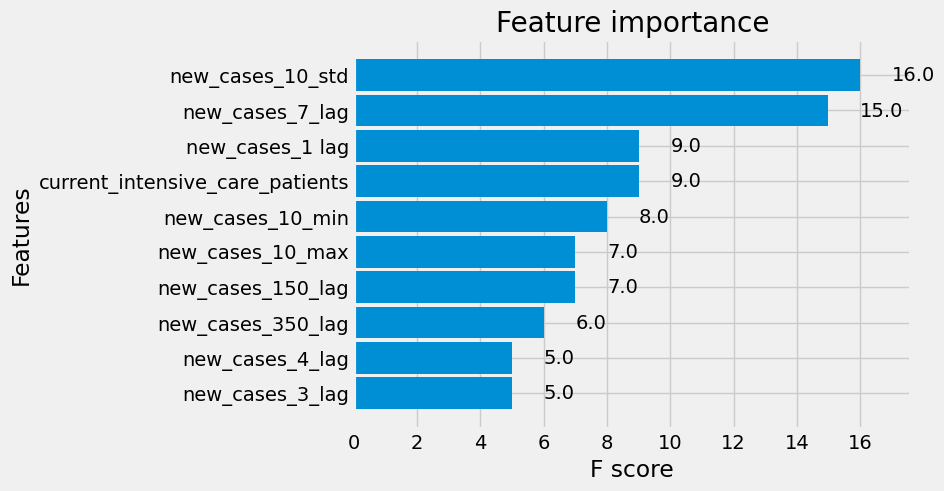

In [107]:
_ = plot_importance(tuned_reg, height=0.9 ,max_num_features = 10)

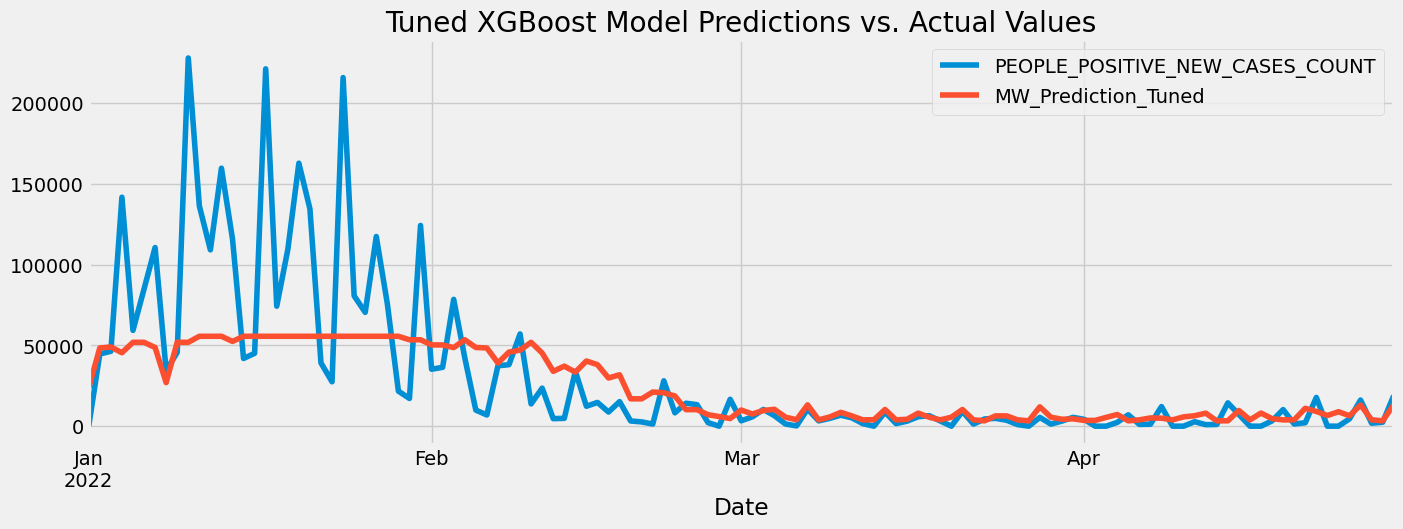

In [108]:
ca_test['MW_Prediction_Tuned'] = tuned_reg.predict(X_ca_test)
_ = ca_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction_Tuned']].plot(figsize=(15, 5), title = 'Tuned XGBoost Model Predictions vs. Actual Values')

In [113]:
model_rmse = mean_squared_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction_Tuned'], squared=False)
model_mae = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction_Tuned'])
print('Tuned Model Test RMSE: ', model_rmse)
print('Tuned Model Test MAE: ', model_mae)

#naive forecast for mase calculation
naive_forecast = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = model_mae / mae_naive
print('Tuned Model Test MASE: ', mase)

Tuned Model Test RMSE:  37918.27523731667
Tuned Model Test MAE:  19556.42831702994
Tuned Model Test MASE:  0.8361130142093334
